In [80]:
import pandas as pd
import nfl_data_py as nfl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from pulp import *
import gurobipy as gp


In [81]:
# NFL-Spielplan 
date = nfl.import_schedules([2019])
clean_date = date[['game_id', 'week', 'home_team', 'away_team' , 'home_score', 'away_score']]

In [82]:
date_1 = nfl.import_schedules([2018])
clean_date_1 = date_1[['game_id', 'week', 'home_team', 'away_team' , 'home_score', 'away_score']]

In [83]:
df_2020 = nfl.import_weekly_data([2020], downcast=True)
df_2020 = df_2020.loc[df_2020['season_type'] == "REG"]
df_2019 = nfl.import_weekly_data([2019], downcast=True)
df_2019 = df_2019.loc[df_2019['season_type'] == "REG"]
df_2018 = nfl.import_weekly_data([2018], downcast=True)
df_2018 = df_2018.loc[df_2018['season_type'] == "REG"]
df_2017 = nfl.import_weekly_data([2017], downcast=True)
df_2017 = df_2017.loc[df_2017['season_type'] == "REG"]

Downcasting floats.
Downcasting floats.
Downcasting floats.
Downcasting floats.


In [84]:
roster = nfl.import_rosters([2019])

In [85]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.fantasypros.com/nfl/reports/leaders/k.php?year=2019"

# Senden Sie eine HTTP-Anfrage an die URL
response = requests.get(url)

# Parsen Sie die HTML-Antwort mit BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Finden Sie die Tabelle in der HTML-Seite
table = soup.find('table')

# Erstellen Sie ein pandas DataFrame aus der Tabelle
df_kicker = pd.read_html(str(table))[0]
df_kicker = df_kicker.merge(roster[['player_name', 'player_id', 'team']], left_on='Player', right_on='player_name', how='left')
df_kicker = df_kicker.drop(['Team', 'player_name', '#'], axis=1)

df_kicker = df_kicker.rename(columns={'team' : 'Team'})

# Setzen Sie die ersten vier Spalten (#, Player, Pos, Team) als Index
df_kicker.set_index(['Player', 'Pos', 'Team', 'AVG', 'TTL', 'player_id'], inplace=True)

# Verwenden Sie die pandas melt-Methode, um das DataFrame zu "schmelzen"
df_long_k = df_kicker.reset_index().melt(id_vars=['Player', 'Pos', 'Team', 'AVG', 'TTL', 'player_id'], var_name='Week', value_name='Points')

# Sortieren Sie das DataFrame nach Player und Week
df_long_k.sort_values(['Player', 'Week'], inplace=True)

# Setzen Sie den Index zurück
df_long_k.reset_index(drop=True, inplace=True) 

In [86]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.fantasypros.com/nfl/reports/leaders/dst.php?year=2019"

# Senden Sie eine HTTP-Anfrage an die URL
response = requests.get(url)

# Parsen Sie die HTML-Antwort mit BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Finden Sie die Tabelle in der HTML-Seite
table = soup.find('table')

# Erstellen Sie ein pandas DataFrame aus der Tabelle
df_defense = pd.read_html(str(table))[0]
# Erstellen Sie eine neue Spalte "team_id", die einen eindeutigen Identifier für jedes Team enthält
df_defense['player_id'] = [(str(i // 1000).zfill(2) + '-' + str(i % 1000).zfill(6)) for i in range(1, len(df_defense) + 1)]

df_defense = df_defense.drop(['#'], axis=1)
# Setzen Sie die ersten vier Spalten (#, Player, Pos, Team) als Index
df_defense.set_index([ 'Player', 'Pos', 'Team', 'AVG', 'TTL','player_id'], inplace=True)

# Verwenden Sie die pandas melt-Methode, um das DataFrame zu "schmelzen"
df_long = df_defense.reset_index().melt(id_vars=['Player', 'Pos', 'Team', 'AVG', 'TTL', 'player_id'], var_name='Week', value_name='Points')

# Sortieren Sie das DataFrame nach Player und Week
df_long.sort_values(['Player', 'Week'], inplace=True)

# Setzen Sie den Index zurück
df_long.reset_index(drop=True, inplace=True)



In [87]:


# Jetzt können Sie df1 und df2 zusammenfügen
df_long_combined = pd.concat([df_long_k, df_long], axis=0, ignore_index=True, sort=False)

df_long_combined = df_long_combined.rename(columns={'Team' : 'recent_team', 'Pos' : 'position_group', 'Points': 'fantasy_points_ppr', 'Week' : 'week', 'Player' : 'player_display_name'})

df_long_combined['week'] = df_long_combined['week'].astype('int32')
df_long_combined['fantasy_points_ppr'] = df_long_combined['fantasy_points_ppr'].replace(['-', 'BYE'], 0).astype('float32')
df_long_combined['recent_team'] = df_long_combined['recent_team'].replace({'JAC': 'JAX', 'LAR': 'LA'})

df_2019_complete = pd.concat([df_2019, df_long_combined], axis=0, ignore_index=True, sort=False)



In [88]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.fantasypros.com/nfl/reports/leaders/k.php?year=2018"

# Senden Sie eine HTTP-Anfrage an die URL
response = requests.get(url)

# Parsen Sie die HTML-Antwort mit BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Finden Sie die Tabelle in der HTML-Seite
table = soup.find('table')

# Erstellen Sie ein pandas DataFrame aus der Tabelle
df_kicker_1 = pd.read_html(str(table))[0]
df_kicker_1 = df_kicker_1.merge(roster[['player_name', 'player_id', 'team']], left_on='Player', right_on='player_name', how='left')
df_kicker_1 = df_kicker_1.drop(['Team', 'player_name', '#'], axis=1)

df_kicker_1 = df_kicker_1.rename(columns={'team' : 'Team'})

# Setzen Sie die ersten vier Spalten (#, Player, Pos, Team) als Index
df_kicker_1.set_index(['Player', 'Pos', 'Team', 'AVG', 'TTL', 'player_id'], inplace=True)

# Verwenden Sie die pandas melt-Methode, um das DataFrame zu "schmelzen"
df_long_k_1 = df_kicker_1.reset_index().melt(id_vars=['Player', 'Pos', 'Team', 'AVG', 'TTL', 'player_id'], var_name='Week', value_name='Points')

# Sortieren Sie das DataFrame nach Player und Week
df_long_k_1.sort_values(['Player', 'Week'], inplace=True)

# Setzen Sie den Index zurück
df_long_k_1.reset_index(drop=True, inplace=True) 

In [89]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.fantasypros.com/nfl/reports/leaders/dst.php?year=2019"

# Senden Sie eine HTTP-Anfrage an die URL
response = requests.get(url)

# Parsen Sie die HTML-Antwort mit BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Finden Sie die Tabelle in der HTML-Seite
table = soup.find('table')

# Erstellen Sie ein pandas DataFrame aus der Tabelle
df_defense = pd.read_html(str(table))[0]
# Erstellen Sie eine neue Spalte "team_id", die einen eindeutigen Identifier für jedes Team enthält
df_defense['player_id'] = [(str(i // 1000).zfill(2) + '-' + str(i % 1000).zfill(6)) for i in range(1, len(df_defense) + 1)]

df_defense = df_defense.drop(['#'], axis=1)
# Setzen Sie die ersten vier Spalten (#, Player, Pos, Team) als Index
df_defense.set_index([ 'Player', 'Pos', 'Team', 'AVG', 'TTL','player_id'], inplace=True)

# Verwenden Sie die pandas melt-Methode, um das DataFrame zu "schmelzen"
df_long_1 = df_defense.reset_index().melt(id_vars=['Player', 'Pos', 'Team', 'AVG', 'TTL', 'player_id'], var_name='Week', value_name='Points')

# Sortieren Sie das DataFrame nach Player und Week
df_long_1.sort_values(['Player', 'Week'], inplace=True)

# Setzen Sie den Index zurück
df_long_1.reset_index(drop=True, inplace=True)



In [90]:


# Jetzt können Sie df1 und df2 zusammenfügen
df_long_combined_1 = pd.concat([df_long_k_1, df_long_1], axis=0, ignore_index=True, sort=False)

df_long_combined_1 = df_long_combined_1.rename(columns={'Team' : 'recent_team', 'Pos' : 'position_group', 'Points': 'fantasy_points_ppr', 'Week' : 'week', 'Player' : 'player_display_name'})

df_long_combined_1['week'] = df_long_combined_1['week'].astype('int32')
df_long_combined_1['fantasy_points_ppr'] = df_long_combined_1['fantasy_points_ppr'].replace(['-', 'BYE'], 0).astype('float32')
df_long_combined_1['recent_team'] = df_long_combined_1['recent_team'].replace({'JAC': 'JAX', 'LAR': 'LA'})

df_2018_complete = pd.concat([df_2018, df_long_combined_1], axis=0, ignore_index=True, sort=False)



In [91]:

new_test = df_2019_complete[['player_id', 'player_display_name', 'position_group', 'recent_team', 'season', 'week', 'fantasy_points', 'fantasy_points_ppr']]
players = new_test
games = clean_date
players['recent_team'] = players['recent_team'].replace('LV', 'OAK')
positions = ['QB', 'TE', 'WR', 'RB', 'K', 'DST']
players_clean = players[players['position_group'].isin(positions)]


/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_1434/1264593803.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['recent_team'] = players['recent_team'].replace('LV', 'OAK')


In [92]:

players_home = players_clean.merge(games, left_on=['recent_team', 'week'], right_on=['home_team', 'week'], how='left')


players_away = players_clean.merge(games, left_on=['recent_team', 'week'], right_on=['away_team', 'week'], how='left')


players_copy = players_clean.copy()
players_home = players_home.reset_index(drop=True)
players_away = players_away.reset_index(drop=True)
players_copy = players_copy.reset_index(drop=True)


players_copy.loc[:, 'opponent'] = players_home['away_team']
nan_rows = players_copy['opponent'].isna()
players_copy.loc[nan_rows, 'opponent'] = players_away.loc[nan_rows, 'home_team']
avg_fantasy_points = players_copy.groupby(['opponent', 'position_group'])['fantasy_points_ppr'].mean().reset_index()

avg_fantasy_points.columns = ['team', 'position_group', 'avg_fantasy_points_allowed']


print(avg_fantasy_points)
#positions = ['QB', 'TE', 'WR', 'RB']
#players_clean = players_copy[players_copy['position_group'].isin(positions)]
#fantasy_clean = avg_fantasy_points[avg_fantasy_points['position_group'].isin(positions)]
players_clean = players_copy.dropna(subset=['opponent'])

home_games = clean_date[['game_id', 'week', 'home_team']].copy()
home_games['is_home'] = True


away_games = clean_date[['game_id', 'week', 'away_team']].copy()
away_games['is_home'] = False


home_games.rename(columns={'home_team': 'recent_team'}, inplace=True)
away_games.rename(columns={'away_team': 'recent_team'}, inplace=True)


games = pd.concat([home_games, away_games])


players = players_clean.merge(games, on=['recent_team', 'week'], how='left')

defense_stats = avg_fantasy_points.rename(columns={'team': 'opponent'})


player_data = players.merge(defense_stats, on=['opponent', 'position_group'], how='left')

    team position_group  avg_fantasy_points_allowed
0    ARI            DST                    8.125000
1    ARI              K                    6.800000
2    ARI             QB                   19.210526
3    ARI             RB                    8.216000
4    ARI             TE                   10.665517
..   ...            ...                         ...
187  WAS              K                    6.142857
188  WAS             QB                   17.328890
189  WAS             RB                   11.142858
190  WAS             TE                    6.300000
191  WAS             WR                    9.744828

[192 rows x 3 columns]


In [93]:
# transform data 218
new_test_1 = df_2018_complete[['player_id', 'player_display_name', 'position_group', 'recent_team', 'season', 'week', 'fantasy_points', 'fantasy_points_ppr']]
players_1= new_test_1
games_1 = clean_date_1
players_1['recent_team'] = players_1['recent_team'].replace('LV', 'OAK')
positions = ['QB', 'TE', 'WR', 'RB', 'K', 'DST']
players_clean_1 = players_1[players_1['position_group'].isin(positions)]

players_home_1 = players_clean_1.merge(games_1, left_on=['recent_team', 'week'], right_on=['home_team', 'week'], how='left')


players_away_1 = players_clean_1.merge(games_1, left_on=['recent_team', 'week'], right_on=['away_team', 'week'], how='left')


players_copy_1 = players_clean_1.copy()
players_home_1 = players_home_1.reset_index(drop=True)
players_away_1 = players_away_1.reset_index(drop=True)
players_copy_1 = players_copy_1.reset_index(drop=True)


players_copy_1.loc[:, 'opponent'] = players_home_1['away_team']
nan_rows_1 = players_copy_1['opponent'].isna()
players_copy_1.loc[nan_rows_1, 'opponent'] = players_away_1.loc[nan_rows_1, 'home_team']
avg_fantasy_points_1 = players_copy_1.groupby(['opponent', 'position_group'])['fantasy_points_ppr'].mean().reset_index()

avg_fantasy_points_1.columns = ['team', 'position_group', 'avg_fantasy_points_allowed']



home_games_1 = clean_date_1[['game_id', 'week', 'home_team']].copy()
home_games_1['is_home'] = True


away_games_1 = clean_date_1[['game_id', 'week', 'away_team']].copy()
away_games_1['is_home'] = False


home_games_1.rename(columns={'home_team': 'recent_team'}, inplace=True)
away_games_1.rename(columns={'away_team': 'recent_team'}, inplace=True)

games_1= pd.concat([home_games_1, away_games_1])


players_1 = players_copy_1.merge(games_1, on=['recent_team', 'week'], how='left')

defense_stats_1 = avg_fantasy_points_1.rename(columns={'team': 'opponent'})


player_data_1 = players_1.merge(defense_stats_1, on=['opponent', 'position_group'], how='left')

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_1434/4028119382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_1['recent_team'] = players_1['recent_team'].replace('LV', 'OAK')


In [94]:
player_data_1

,player_id,player_display_name,position_group,recent_team,season,week,fantasy_points,fantasy_points_ppr,opponent,game_id,is_home,avg_fantasy_points_allowed
0,00-0019596,Tom Brady,QB,NE,2018.0,1,21.280001,21.280001,HOU,2018_01_HOU_NE,True,13.505000
1,00-0019596,Tom Brady,QB,NE,2018.0,2,16.360001,16.360001,JAX,2018_02_NE_JAX,False,14.980000
2,00-0019596,Tom Brady,QB,NE,2018.0,3,7.520000,7.520000,DET,2018_03_NE_DET,False,15.514445
3,00-0019596,Tom Brady,QB,NE,2018.0,4,18.959999,18.959999,MIA,2018_04_MIA_NE,True,14.254286
4,00-0019596,Tom Brady,QB,NE,2018.0,5,27.540001,27.540001,IND,2018_05_IND_NE,True,14.258889
...,...,...,...,...,...,...,...,...,...,...,...,...
6233,00-000023,Washington Commanders,DST,WAS,NaN,5,NaN,5.000000,NO,2018_05_WAS_NO,False,6.375000
6234,00-000023,Washington Commanders,DST,WAS,NaN,6,NaN,10.000000,CAR,2018_06_CAR_WAS,True,9.000000
6235,00-000023,Washington Commanders,DST,WAS,NaN,7,NaN,8.000000,DAL,2018_07_DAL_WAS,True,7.375000
6236,00-000023,Washington Commanders,DST,WAS,NaN,8,NaN,6.000000,NYG,2018_08_WAS_NYG,False,7.500000


In [95]:
# Calculate mean and variance of fantasy points for each player
player_data_1['mean_fantasy_points'] = player_data_1.groupby('player_id')['fantasy_points_ppr'].transform('mean')
player_data_1['var_fantasy_points'] = player_data_1.groupby('player_id')['fantasy_points_ppr'].transform('var')


In [96]:
# Calculate the mean and variance of fantasy points for each player in 2018
mean_fantasy_points_2018 = player_data_1.groupby('player_id')['fantasy_points_ppr'].mean()
var_fantasy_points_2018 = player_data_1.groupby('player_id')['fantasy_points_ppr'].var()

# Add these stats to the 2019 player data
player_data = player_data.merge(mean_fantasy_points_2018, on='player_id', how='left')
player_data = player_data.merge(var_fantasy_points_2018, on='player_id', how='left')

# Rename the new columns
player_data.rename(columns={'fantasy_points_ppr_x': 'fantasy_points_ppr', 'fantasy_points_ppr_y': 'mean_fantasy_points', 'fantasy_points_ppr' : 'var_fantasy_points'}, inplace=True)



In [19]:
player_data

,player_id,player_display_name,position_group,recent_team,season,week,fantasy_points,fantasy_points_ppr,opponent,game_id,is_home,avg_fantasy_points_allowed,mean_fantasy_points,var_fantasy_points
0,00-0019596,Tom Brady,QB,NE,2019.0,1,25.639999,25.639999,PIT,2019_01_PIT_NE,True,9.781904,17.581249,42.888187
1,00-0019596,Tom Brady,QB,NE,2019.0,2,24.660000,24.660000,MIA,2019_02_NE_MIA,False,17.046001,17.581249,42.888187
2,00-0019596,Tom Brady,QB,NE,2019.0,3,20.139999,20.139999,NYJ,2019_03_NYJ_NE,True,11.584348,17.581249,42.888187
3,00-0019596,Tom Brady,QB,NE,2019.0,4,3.700000,3.700000,BUF,2019_04_NE_BUF,False,12.521250,17.581249,42.888187
4,00-0019596,Tom Brady,QB,NE,2019.0,5,23.920000,23.920000,WAS,2019_05_NE_WAS,False,17.328890,17.581249,42.888187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6200,00-000023,Washington Commanders,DST,WAS,NaN,5,NaN,5.000000,NE,2019_05_NE_WAS,True,6.062500,5.529412,29.139708
6201,00-000023,Washington Commanders,DST,WAS,NaN,6,NaN,10.000000,MIA,2019_06_WAS_MIA,False,9.625000,5.529412,29.139708
6202,00-000023,Washington Commanders,DST,WAS,NaN,7,NaN,8.000000,SF,2019_07_SF_WAS,True,5.875000,5.529412,29.139708
6203,00-000023,Washington Commanders,DST,WAS,NaN,8,NaN,6.000000,MIN,2019_08_WAS_MIN,False,4.625000,5.529412,29.139708


In [102]:

player_data_2018 = player_data_1


player_stats_2018 = player_data_2018.groupby('player_id')['fantasy_points_ppr'].agg(['mean', 'var']).reset_index()

player_data_2019 = player_data
player_data_2019 = player_data_2019.merge(player_stats_2018, on='player_id', how='left')
player_data_2019.rename(columns={'mean': 'mean_fantasy_points_2018', 'var': 'var_fantasy_points_2018'}, inplace=True)


team_stats_2018 = player_data_2018.groupby(['recent_team', 'position_group'])['avg_fantasy_points_allowed'].mean().reset_index()


player_data_2019 = player_data_2019.merge(team_stats_2018, on=['recent_team', 'position_group'], how='left')
player_data_2019.rename(columns={'avg_fantasy_points_allowed_x	': 'avg_fantasy_points_allowed', 'fantasy_points_ppr_y': 'mean_fantasy_points'}, inplace=True)
player_data_2019 = player_data_2019.drop(['mean_fantasy_points', 'var_fantasy_points', 'avg_fantasy_points_allowed_y'], axis=1)


In [103]:
player_data_2019 = player_data_2019.dropna(subset=['mean_fantasy_points_2018', 'var_fantasy_points_2018', 'is_home', 'avg_fantasy_points_allowed_x', 'fantasy_points_ppr'])


In [99]:
player_data_2019

,player_id,player_display_name,position_group,recent_team,season,week,fantasy_points,fantasy_points_ppr,opponent,game_id,is_home,avg_fantasy_points_allowed_x,mean_fantasy_points_2018,var_fantasy_points_2018
0,00-0019596,Tom Brady,QB,NE,2019.0,1,25.639999,25.639999,PIT,2019_01_PIT_NE,True,9.781904,17.581249,42.888187
1,00-0019596,Tom Brady,QB,NE,2019.0,2,24.660000,24.660000,MIA,2019_02_NE_MIA,False,17.046001,17.581249,42.888187
2,00-0019596,Tom Brady,QB,NE,2019.0,3,20.139999,20.139999,NYJ,2019_03_NYJ_NE,True,11.584348,17.581249,42.888187
3,00-0019596,Tom Brady,QB,NE,2019.0,4,3.700000,3.700000,BUF,2019_04_NE_BUF,False,12.521250,17.581249,42.888187
4,00-0019596,Tom Brady,QB,NE,2019.0,5,23.920000,23.920000,WAS,2019_05_NE_WAS,False,17.328890,17.581249,42.888187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6200,00-000023,Washington Commanders,DST,WAS,NaN,5,NaN,5.000000,NE,2019_05_NE_WAS,True,6.062500,5.529412,29.139708
6201,00-000023,Washington Commanders,DST,WAS,NaN,6,NaN,10.000000,MIA,2019_06_WAS_MIA,False,9.625000,5.529412,29.139708
6202,00-000023,Washington Commanders,DST,WAS,NaN,7,NaN,8.000000,SF,2019_07_SF_WAS,True,5.875000,5.529412,29.139708
6203,00-000023,Washington Commanders,DST,WAS,NaN,8,NaN,6.000000,MIN,2019_08_WAS_MIN,False,4.625000,5.529412,29.139708


In [105]:
from sklearn.linear_model import LinearRegression

features = ['mean_fantasy_points_2018', 'var_fantasy_points_2018', 'is_home', 'avg_fantasy_points_allowed_x']
target = 'fantasy_points_ppr'
model = LinearRegression()
X_train = player_data_2019[features]
y_train = player_data_2019[target]
model.fit(X_train, y_train)


model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [106]:
from sklearn.metrics import mean_absolute_error

X_test = player_data_2019[features]
X_test = X_test.fillna(X_test.mean())

y_test = player_data_2019[target]


predicted_points = model.predict(X_test)


mae = mean_absolute_error(y_test, predicted_points)
print(f"Mean Absolute Error: {mae}")


player_data_2019['predicted_fantasy_points'] = predicted_points


Mean Absolute Error: 5.206129550933838


In [ ]:
import matplotlib.pyplot as plt

# Berechnen der Residuen für jede Vorhersage
residuals = y_test - predicted_points

# Erzeugen des Histogramms
plt.hist(residuals, bins=range(int(np.min(residuals)), int(np.max(residuals)) + 1, 1))
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Speichern des Diagramms als PDF
plt.savefig('residuals_distribution.pdf', format='pdf')

plt.show()

In [163]:
from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


predicted_points = model.predict(X_test)


mae = mean_absolute_error(y_test, predicted_points)
print(f"Mean Absolute Error: {mae}")


player_data_2019['predicted_fantasy_points'] = predicted_points


Mean Absolute Error: 1.9426652793094747


In [ ]:
import matplotlib.pyplot as plt

# Berechnen der Residuen für jede Vorhersage
residuals = y_test - predicted_points

# Erzeugen des Histogramms
plt.hist(residuals, bins=range(int(np.min(residuals)), int(np.max(residuals)) + 1, 1))
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Speichern des Diagramms als PDF
plt.savefig('residuals_distribution_random_forrest.pdf', format='pdf')

plt.show()

In [107]:
player_data_2019

,player_id,player_display_name,position_group,recent_team,season,week,fantasy_points,fantasy_points_ppr,opponent,game_id,is_home,avg_fantasy_points_allowed_x,mean_fantasy_points_2018,var_fantasy_points_2018,predicted_fantasy_points
0,00-0019596,Tom Brady,QB,NE,2019.0,1,25.639999,25.639999,PIT,2019_01_PIT_NE,True,9.781904,17.581249,42.888187,14.678169
1,00-0019596,Tom Brady,QB,NE,2019.0,2,24.660000,24.660000,MIA,2019_02_NE_MIA,False,17.046001,17.581249,42.888187,18.998936
2,00-0019596,Tom Brady,QB,NE,2019.0,3,20.139999,20.139999,NYJ,2019_03_NYJ_NE,True,11.584348,17.581249,42.888187,15.777155
3,00-0019596,Tom Brady,QB,NE,2019.0,4,3.700000,3.700000,BUF,2019_04_NE_BUF,False,12.521250,17.581249,42.888187,16.240105
4,00-0019596,Tom Brady,QB,NE,2019.0,5,23.920000,23.920000,WAS,2019_05_NE_WAS,False,17.328890,17.581249,42.888187,19.171419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6200,00-000023,Washington Commanders,DST,WAS,NaN,5,NaN,5.000000,NE,2019_05_NE_WAS,True,6.062500,5.529412,29.139708,5.413315
6201,00-000023,Washington Commanders,DST,WAS,NaN,6,NaN,10.000000,MIA,2019_06_WAS_MIA,False,9.625000,5.529412,29.139708,7.477145
6202,00-000023,Washington Commanders,DST,WAS,NaN,7,NaN,8.000000,SF,2019_07_SF_WAS,True,5.875000,5.529412,29.139708,5.298993
6203,00-000023,Washington Commanders,DST,WAS,NaN,8,NaN,6.000000,MIN,2019_08_WAS_MIN,False,4.625000,5.529412,29.139708,4.428545


In [148]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

url = 'https://www.fantasypros.com/nfl/adp/ppr-overall.php?year=2019'

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', attrs={'id': 'data'})

headers = [header.text for header in table.find_all('th')]

# Wir interessieren uns nur für diese Spalten
interested_cols = ['Rank', 'Player Team (Bye)', 'POS', 'AVG']

# Finde die Indizes der Spalten, an denen wir interessiert sind
interested_indices = [headers.index(col) for col in interested_cols]

rows = table.find_all('tr')
table_data = []

for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    row_data = [cols[index] for index in interested_indices if index < len(cols)]

    # Füge die Zeile hinzu, wenn sie Daten enthält
    if row_data:
        table_data.append(row_data)

# Erstellen Sie das DataFrame mit den interessierenden Spalten
df = pd.DataFrame(table_data, columns=interested_cols)

# Hinzufügen der 'Sleeper' Spalte mit NaN Werten
df['Sleeper'] = np.nan 

# Liste aller Team-Kürzel
team_abbrs = ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 
              'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 
              'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 
              'SEA', 'SF', 'TB', 'TEN', 'WAS', 'II', 'Jr.' ,'DST']

def extract_info(row):
    player = row
    team = None
    bye = None

    # Extrahieren Sie die Bye-Week, wenn sie vorhanden ist
    if '(' in row and ')' in row:
        bye = row[row.index('(')+1:row.index(')')]
        player = row[:row.index('(')].strip()

    # Prüfen Sie, ob das letzte Wort im Spieler-Feld ein Team-Kürzel ist
    last_word = player.split(' ')[-1]
    if last_word in team_abbrs:
        team = last_word
        player = ' '.join(player.split(' ')[:-1])

    # Prüfen Sie, ob das letzte Wort im Spieler-Feld "Jr." oder "II" ist
    last_word = player.split(' ')[-1]
    if last_word in ["Jr.", "II"]:
        player = ' '.join(player.split(' ')[:-1])

    return player, team, bye

# Anwendung der Funktion auf jede Zeile in der "Player Team (Bye)" Spalte
df[['Player', 'Team', 'Bye']] = df['Player Team (Bye)'].apply(extract_info).apply(pd.Series)

# Löschen der ursprünglichen Spalte "Player Team (Bye)"
df = df.drop(columns=['Player Team (Bye)'])

# Zusammenführen der beiden DataFrames auf der Basis unterschiedlicher Spaltennamen
df = pd.merge(df, player_data[['player_display_name', 'player_id']], left_on='Player', right_on='player_display_name', how='left')

# Löschen der zusätzlichen Spalte "player_display_name"
df = df.drop(columns=['player_display_name'])

# Entfernen von Duplikaten und Beibehalten des ersten Auftreffens jeder player_id
df = df.drop_duplicates(subset='player_id', keep='first')

print(df)


      Rank    POS    AVG  Sleeper               Player  Team   Bye   player_id
0        1    RB1    1.0      NaN       Saquon Barkley   NYG    11  00-0034844
13       2    RB2    2.5      NaN  Christian McCaffrey    SF     4  00-0033280
29       3    RB3    2.5      NaN         Alvin Kamara    NO     9  00-0033906
43       4    RB4    4.0      NaN      Ezekiel Elliott  None  None  00-0033045
59       5    WR1    5.3      NaN      DeAndre Hopkins  None  None  00-0030564
...    ...    ...    ...      ...                  ...   ...   ...         ...
5977  1037  QB126  945.0      NaN           Colt McCoy   ARI    12  00-0027688
5981  1041  RB258  961.0      NaN         Buddy Howell  None  None  00-0034449
5983  1042  QB127  962.0      NaN         Nick Mullens   MIN    12  00-0033319
5985  1044  RB260  973.0      NaN       Raheem Mostert   MIA     5  00-0031687
6001  1046  TE188  979.0      NaN          Dawson Knox   BUF     6  00-0035689

[546 rows x 8 columns]


In [109]:
# Durchschnittliche vorhergesagte Punkte über die Saison für jeden Spieler
players_season_avg_2018 = player_data_2018.groupby(['player_id', 'player_display_name', 'position_group'])['fantasy_points_ppr'].mean().reset_index()

# Summe der vorhergesagten Punkte über die Saison für jeden Spieler
players_season_sum_2018 = player_data_2018.groupby(['player_id', 'player_display_name', 'position_group'])['fantasy_points_ppr'].sum().reset_index()

players_season_sum_2018.sort_values('fantasy_points_ppr', ascending=False)

,player_id,player_display_name,position_group,fantasy_points_ppr
505,00-0033873,Patrick Mahomes,QB,417.079987
626,00-0034844,Saquon Barkley,RB,385.799988
437,00-0033280,Christian McCaffrey,RB,385.500000
353,00-0032241,Todd Gurley,RB,372.100006
66,00-0026143,Matt Ryan,QB,354.959991
...,...,...,...,...
77,00-0026625,Brian Hoyer,QB,-0.520000
430,00-0033119,Jacoby Brissett,QB,-0.620000
146,00-0029129,Rod Streater,WR,-1.100000
226,00-0030565,Geno Smith,QB,-1.480000


In [110]:
# Durchschnittliche vorhergesagte Punkte über die Saison für jeden Spieler
players_season_avg_2019 = player_data_2019.groupby(['player_id', 'player_display_name', 'position_group'])['predicted_fantasy_points'].mean().reset_index()

# Summe der vorhergesagten Punkte über die Saison für jeden Spieler
players_season_sum_2019 = player_data_2019.groupby(['player_id', 'player_display_name', 'position_group'])['predicted_fantasy_points'].sum().reset_index()

players_season_sum_2019.sort_values('predicted_fantasy_points', ascending=False)

,player_id,player_display_name,position_group,predicted_fantasy_points
352,00-0033873,Patrick Mahomes,QB,309.313049
60,00-0026143,Matt Ryan,QB,307.830933
299,00-0033106,Jared Goff,QB,306.878693
44,00-0023459,Aaron Rodgers,QB,304.216370
48,00-0023682,Ryan Fitzpatrick,QB,296.392303
...,...,...,...,...
279,00-0032795,Cody Core,WR,4.928842
88,00-0028063,Taiwan Jones,RB,4.455371
94,00-0028114,Dwayne Harris,WR,4.368266
327,00-0033526,Samaje Perine,RB,3.390179


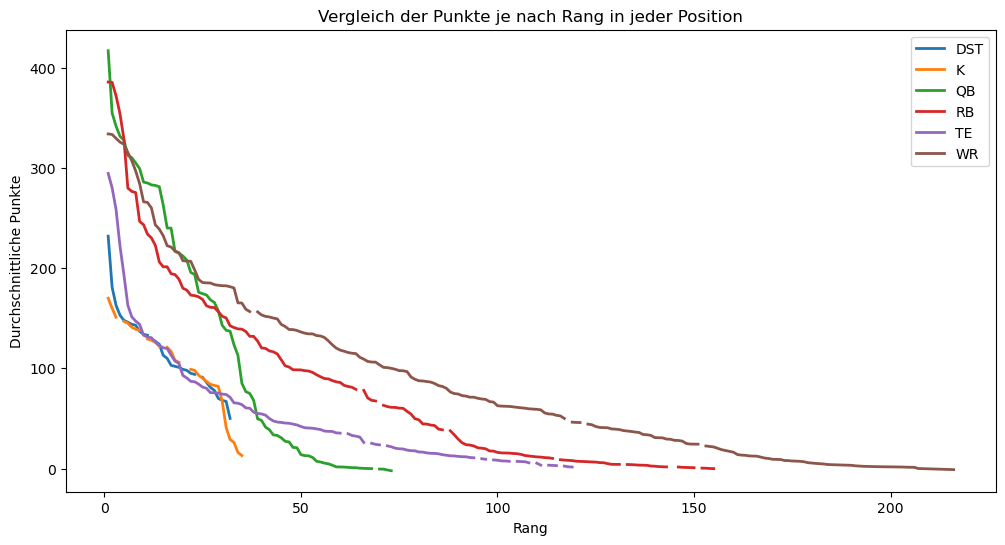

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
df = players_season_sum_2018
# Ich gehe davon aus, dass 'df' Ihr DataFrame ist
# Sortieren Sie den DataFrame nach 'predicted_fantasy_points' in absteigender Reihenfolge
df = df.sort_values('fantasy_points_ppr', ascending=False)

# Gruppieren Sie den DataFrame nach 'position_group' und erstellen Sie einen Rang innerhalb jeder Gruppe
df['rank'] = df.groupby('position_group')['fantasy_points_ppr'].rank(ascending=False, method='min')

# Erstellen Sie einen Pivot-Tisch, der die durchschnittlichen 'predicted_fantasy_points' für jeden Rang in jeder 'position_group' zeigt
pivot_df = df.pivot_table(values='fantasy_points_ppr', index='rank', columns='position_group')

# Zeichnen Sie das Liniendiagramm
plt.figure(figsize=(12, 6))
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], marker='', linewidth=2, label=column)

plt.legend()
plt.title('Vergleich der Punkte je nach Rang in jeder Position')
plt.xlabel('Rang')
plt.ylabel('Durchschnittliche Punkte')
# Speichern Sie das Diagramm als PDF
plt.savefig("line_plot.pdf", format='pdf')

# Die Zeile unten zeigt das Diagramm an. Beachten Sie, dass plt.show() nach plt.savefig() aufgerufen werden sollte.
plt.show()

In [150]:
players_rank = players_season_sum_2019.copy()

# Rang basierend auf den vorhergesagten Fantasy-Punkten hinzufügen
players_rank['rank'] = players_rank['predicted_fantasy_points'].rank(ascending=False, method='min')

players_rank


,player_id,player_display_name,position_group,predicted_fantasy_points,rank
0,00-000001,New England Patriots,DST,190.555435,53.0
1,00-000002,Pittsburgh Steelers,DST,150.862930,94.0
2,00-000003,San Francisco 49ers,DST,143.592712,100.0
3,00-000004,Baltimore Ravens,DST,139.463806,108.0
4,00-000005,Kansas City Chiefs,DST,122.725281,133.0
...,...,...,...,...,...
444,00-0034855,Baker Mayfield,QB,260.884644,20.0
445,00-0034857,Josh Allen,QB,288.146362,11.0
446,00-0034860,Dante Pettis,WR,98.869705,197.0
447,00-0034867,Malik Turner,WR,45.739105,325.0


In [151]:
df = df.merge(players_rank[['player_id', 'predicted_fantasy_points', 'position_group']], on='player_id', how='left')

df = df.dropna(subset=['predicted_fantasy_points', 'position_group'])


In [147]:


df = df.merge(players_rank[['player_id', 'predicted_fantasy_points']], on='player_id', how='left')

df = df.dropna(subset=['predicted_fantasy_points'])


KeyError: "['position_group'] not in index"

In [154]:
players_rank = df
players_rank['AVG'] = players_rank['AVG'].astype(float)

In [155]:
players = players_rank.sort_values(by=['position_group', 'predicted_fantasy_points'], ascending=[True, False])
# Setzen Sie den ADP auf 100
adp_cutoff = 100
# Fügen Sie den 'replacement_value' für jeden Spieler hinzu
def calculate_replacement_value(row):
    if row['position_group'] in replacement_players.index:
        return replacement_players.loc[row['position_group'], 'predicted_fantasy_points']
    else:
        return 0  # Oder einen anderen geeigneten Standardwert



# Wählen Sie die Spieler aus, die bis zum ADP-Cutoff ausgewählt wurden
drafted_players = players[players['AVG'] <= adp_cutoff]

# Finden Sie den letzten ausgewählten Spieler für jede Position
replacement_players = drafted_players.groupby('position_group').last()
players['replacement_value'] = players.apply(calculate_replacement_value, axis=1)
# Fügen Sie den 'replacement_value' für jeden Spieler hinzu
#players['replacement_value'] = players.apply(lambda row: replacement_players.loc[row['position_group'], 'predicted_fantasy_points'], axis=1)

# Berechnen Sie den 'vor' für jeden Spieler
players['vor'] = players['predicted_fantasy_points'] - players['replacement_value']

# Sortieren Sie die Spieler nach 'vor' für die endgültige Draft-Reihenfolge
players = players.sort_values('vor', ascending=False)

# Erstelle eine neue Spalte 'rank', die den Rang des Spielers basierend auf dem VOR repräsentiert
players['rank'] = players['vor'].rank(ascending=False, method='min')

players_rank = players


In [156]:
players_rank

,Rank,POS,AVG,Sleeper,Player,Team,Bye,player_id,predicted_fantasy_points,position_group,replacement_value,vor,rank
10,11,WR4,10.7,NaN,Michael Thomas,NO,9,00-0032765,258.939514,WR,17.357178,241.582336,1.0
9,10,WR3,10.5,NaN,Julio Jones,None,None,00-0027944,241.330353,WR,17.357178,223.973175,2.0
4,5,WR1,5.3,NaN,DeAndre Hopkins,None,None,00-0030564,239.952255,WR,17.357178,222.595078,3.0
11,12,WR5,12.8,NaN,Odell Beckham,BAL,8,00-0031235,237.120972,WR,17.357178,219.763794,4.0
81,93,WR39,97.8,NaN,Emmanuel Sanders,None,None,00-0027685,231.151871,WR,17.357178,213.794693,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,672,QB87,541.0,NaN,Sean Mannion,None,None,00-0032245,19.976408,QB,221.561752,-201.585344,398.0
489,783,QB98,662.0,NaN,Mike Glennon,None,None,00-0030520,17.617748,QB,221.561752,-203.944004,399.0
543,1042,QB127,962.0,NaN,Nick Mullens,MIN,12,00-0033319,14.515570,QB,221.561752,-207.046183,400.0
401,574,QB63,446.0,NaN,AJ McCarron,None,None,00-0031288,12.610646,QB,221.561752,-208.951106,401.0


In [118]:
# Gruppiere und sortiere  nach 'position_group' und 'predicted_fantasy_points'
players = players_season_avg_2019.sort_values(by=['position_group', 'predicted_fantasy_points'], ascending=[True, False])

# Berechne 'opportunity_cost' innerhalb jeder 'position_group'
players['opportunity_cost'] = players.groupby('position_group')['predicted_fantasy_points'].diff(-1).abs()

# Ersetze  NaN-Werte in 'opportunity_cost' durch 0
players['opportunity_cost'].fillna(0, inplace=True)

# Berechne 'final_score' mit einer Gewichtung für 'predicted_fantasy_points' und 'opportunity_cost'
weights = {'QB': {'predicted_fantasy_points': 0.5, 'opportunity_cost': 0.5},
           'RB': {'predicted_fantasy_points': 0.5, 'opportunity_cost': 0.5},
           'WR': {'predicted_fantasy_points': 0.5, 'opportunity_cost': 0.5},
           'TE': {'predicted_fantasy_points': 0.5, 'opportunity_cost': 0.5},
           'K': {'predicted_fantasy_points': 0.5, 'opportunity_cost': 0.5},
           'DST': {'predicted_fantasy_points': 0.5, 'opportunity_cost': 0.5}
          }

# Berechne  'final_score' mit einer Gewichtung für 'predicted_fantasy_points' und 'opportunity_cost'
players['final_score'] = players.apply(lambda row: row['predicted_fantasy_points']*weights[row['position_group']]['predicted_fantasy_points'] 
                                       + row['opportunity_cost']*weights[row['position_group']]['opportunity_cost'], axis=1)

# Sortiere nach 'final_score' für die endgültige Draft-Reihenfolge
players = players.sort_values('final_score', ascending=False)
# Erstelle eine neue Spalte 'rank', die den Rang des Spielers basierend auf dem final_score repräsentiert
players['rank'] = players['final_score'].rank(ascending=False, method='min')

players_rank = players
players_rank

,player_id,player_display_name,position_group,predicted_fantasy_points,opportunity_cost,final_score,rank
352,00-0033873,Patrick Mahomes,QB,22.093790,1.571728,11.832759,1.0
60,00-0026143,Matt Ryan,QB,20.522062,0.380085,10.451074,2.0
34,00-0020531,Drew Brees,QB,20.141977,0.382490,10.262234,3.0
250,00-0032241,Todd Gurley,RB,19.285734,0.885979,10.085856,4.0
48,00-0023682,Ryan Fitzpatrick,QB,19.759487,0.371452,10.065470,5.0
...,...,...,...,...,...,...,...
101,00-0028787,Kai Forbath,K,2.359689,0.332460,1.346074,445.0
45,00-0023482,Mike Nugent,K,2.626030,0.036152,1.331091,446.0
218,00-0031690,Eric Tomlinson,TE,2.080837,0.244328,1.162583,447.0
304,00-0033138,Sam Ficken,K,2.027229,0.000000,1.013614,448.0


In [133]:
df

,Rank,POS,AVG,Sleeper,Player,Team,Bye,player_id
0,1,RB1,1.0,NaN,Saquon Barkley,NYG,11,00-0034844
13,2,RB2,2.5,NaN,Christian McCaffrey,SF,4,00-0033280
29,3,RB3,2.5,NaN,Alvin Kamara,NO,9,00-0033906
43,4,RB4,4.0,NaN,Ezekiel Elliott,None,None,00-0033045
59,5,WR1,5.3,NaN,DeAndre Hopkins,None,None,00-0030564
...,...,...,...,...,...,...,...,...
5977,1037,QB126,945.0,NaN,Colt McCoy,ARI,12,00-0027688
5981,1041,RB258,961.0,NaN,Buddy Howell,None,None,00-0034449
5983,1042,QB127,962.0,NaN,Nick Mullens,MIN,12,00-0033319
5985,1044,RB260,973.0,NaN,Raheem Mostert,MIA,5,00-0031687


In [158]:
# Umwandeln der 'rank' Spalte in 'float'
players_rank['rank'] = players_rank['rank'].astype(float)

# Zusammenführen der beiden DataFrames basierend auf 'player_id'
merged_df = pd.merge(df, players_rank, on='player_id')

merged_df['AVG'] = merged_df['AVG'].astype(float)


# Berechnen des Durchschnittsrangs
merged_df['average_rank'] = merged_df[['rank', 'AVG']].mean(axis=1)

# Ausgeben des neuen DataFrames mit Durchschnittsrängen
print(merged_df)


KeyError: 'AVG'

In [159]:
players_rank.to_csv('rank.csv')

In [131]:
merged_df.to_csv('rank.csv')

In [132]:
player_data_2019.to_csv('player_data.csv')

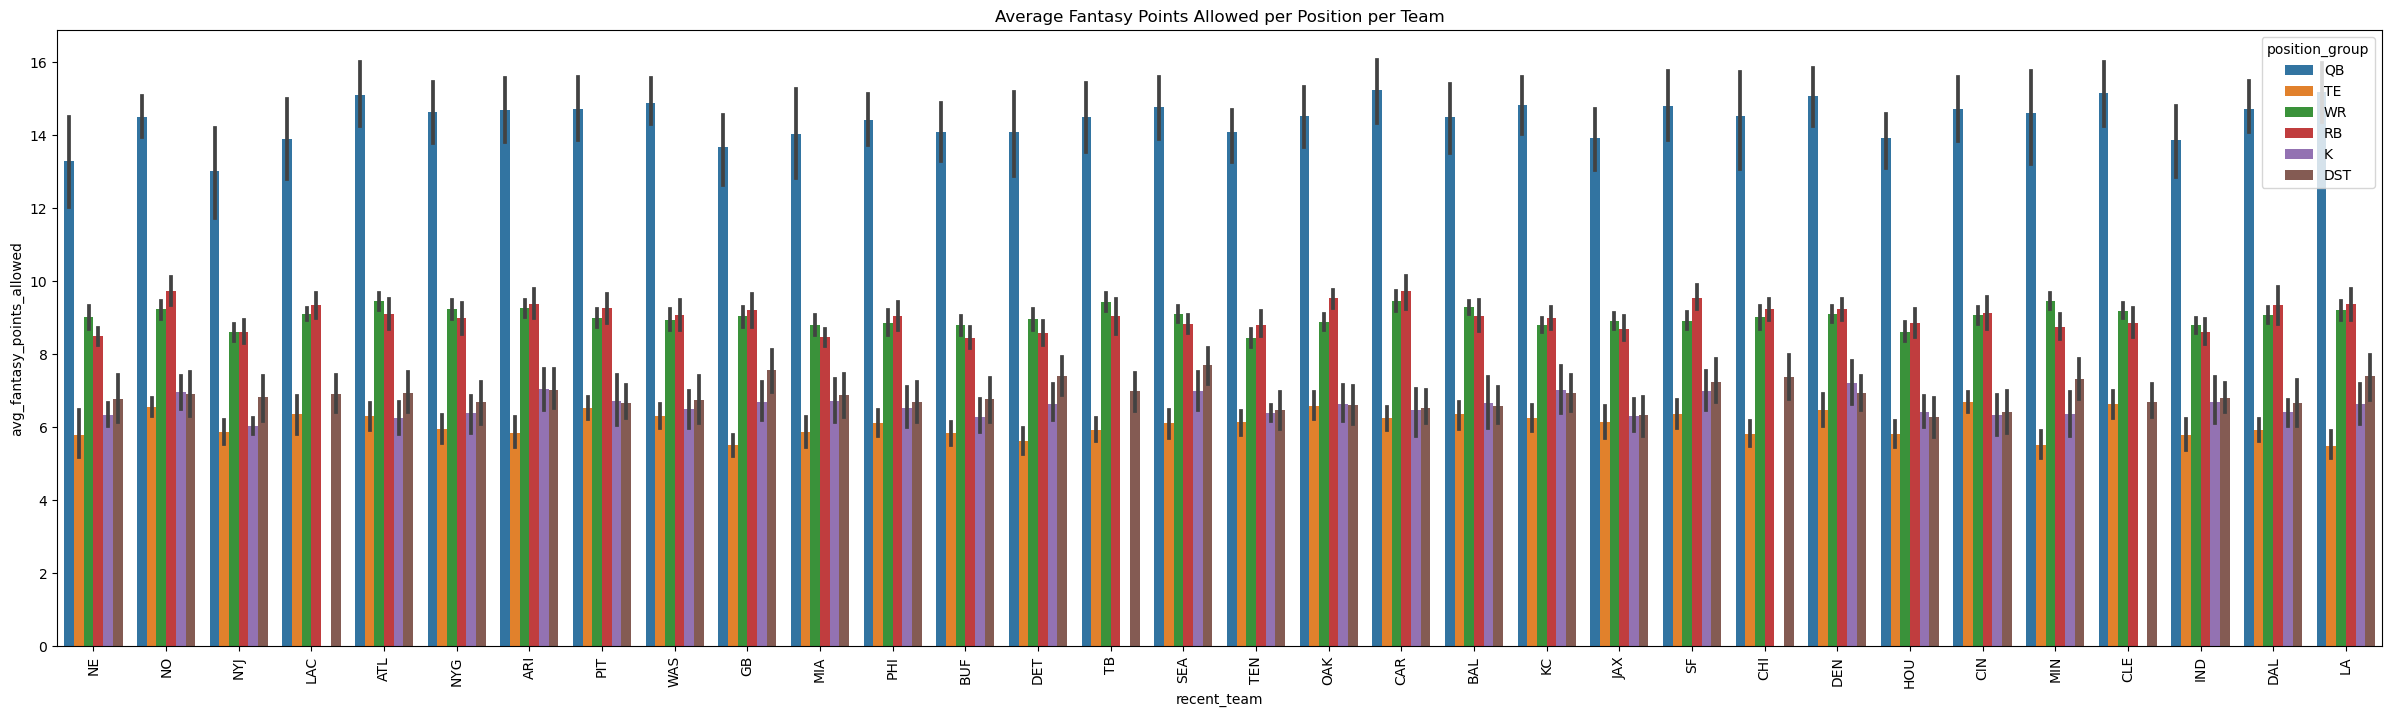

In [56]:
plt.figure(figsize=(30,8))
sns.barplot(x='recent_team', y='avg_fantasy_points_allowed', hue='position_group', data=player_data_1)
plt.xticks(rotation=90)
plt.title('Average Fantasy Points Allowed per Position per Team')
plt.show()

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_74148/1696892848.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(y='recent_team', x='avg_fantasy_points_allowed', hue='position_group', data=player_data_1, ci=None)


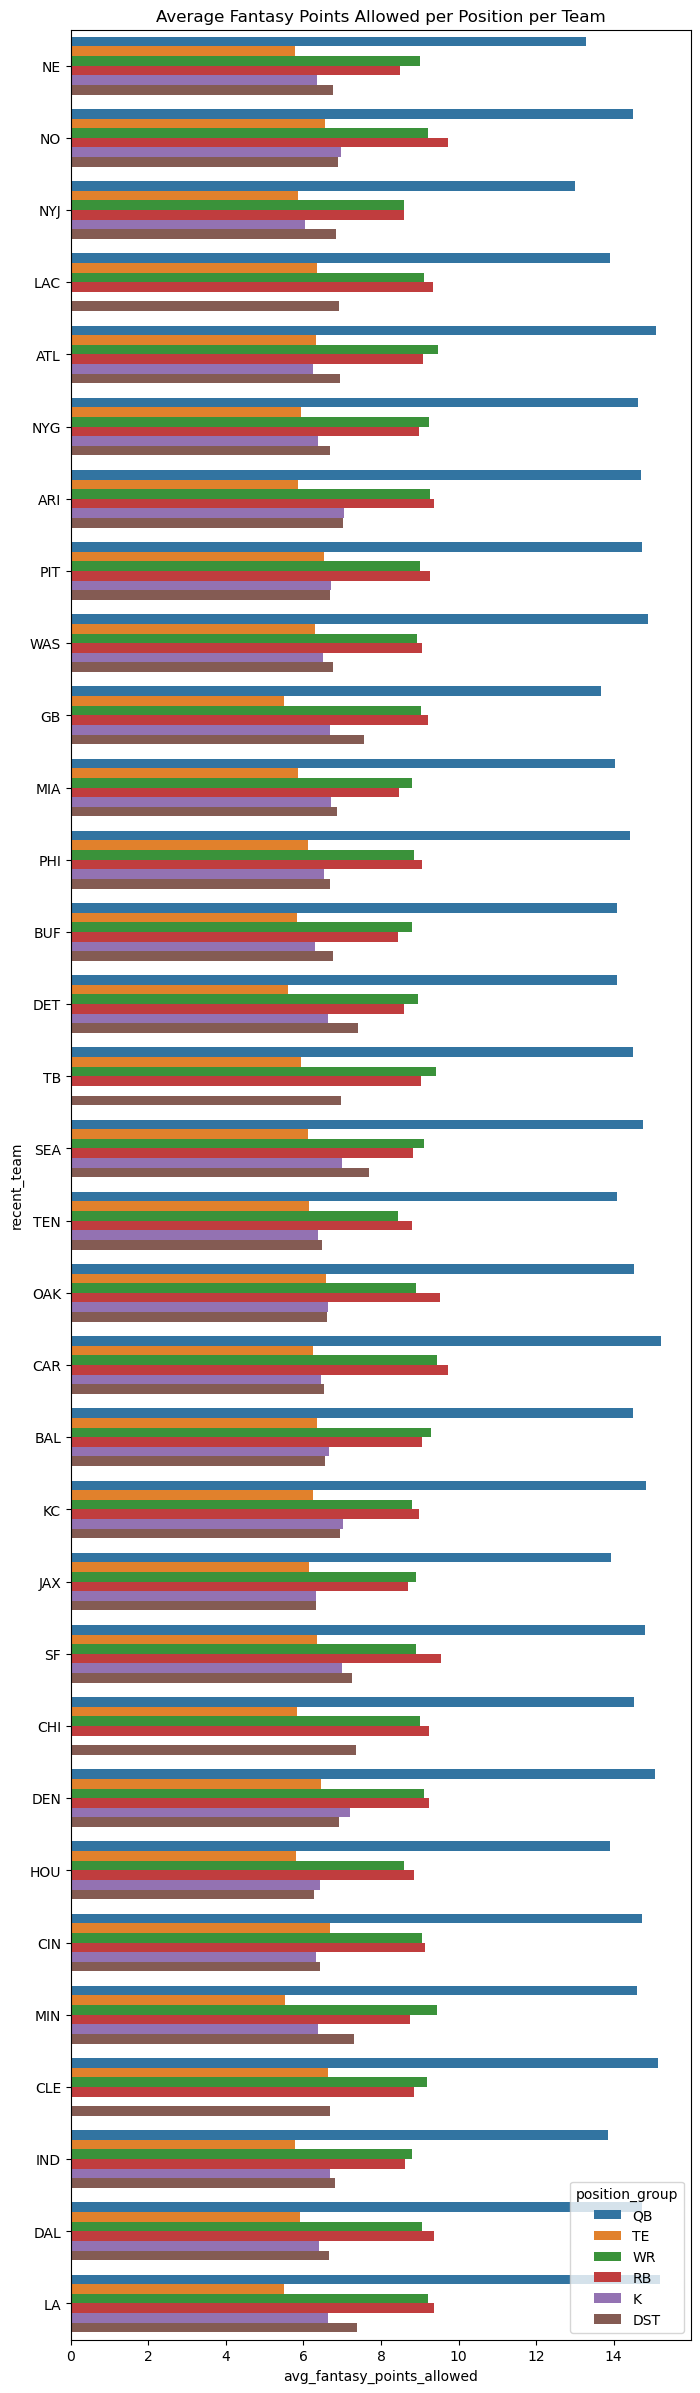

In [148]:
plt.figure(figsize=(8,30))
sns.barplot(y='recent_team', x='avg_fantasy_points_allowed', hue='position_group', data=player_data_1, ci=None)
plt.title('Average Fantasy Points Allowed per Position per Team')
plt.show()


/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_74148/3539369122.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(y='recent_team', x='avg_fantasy_points_allowed', hue='position_group', data=player_data_1, ci=None)


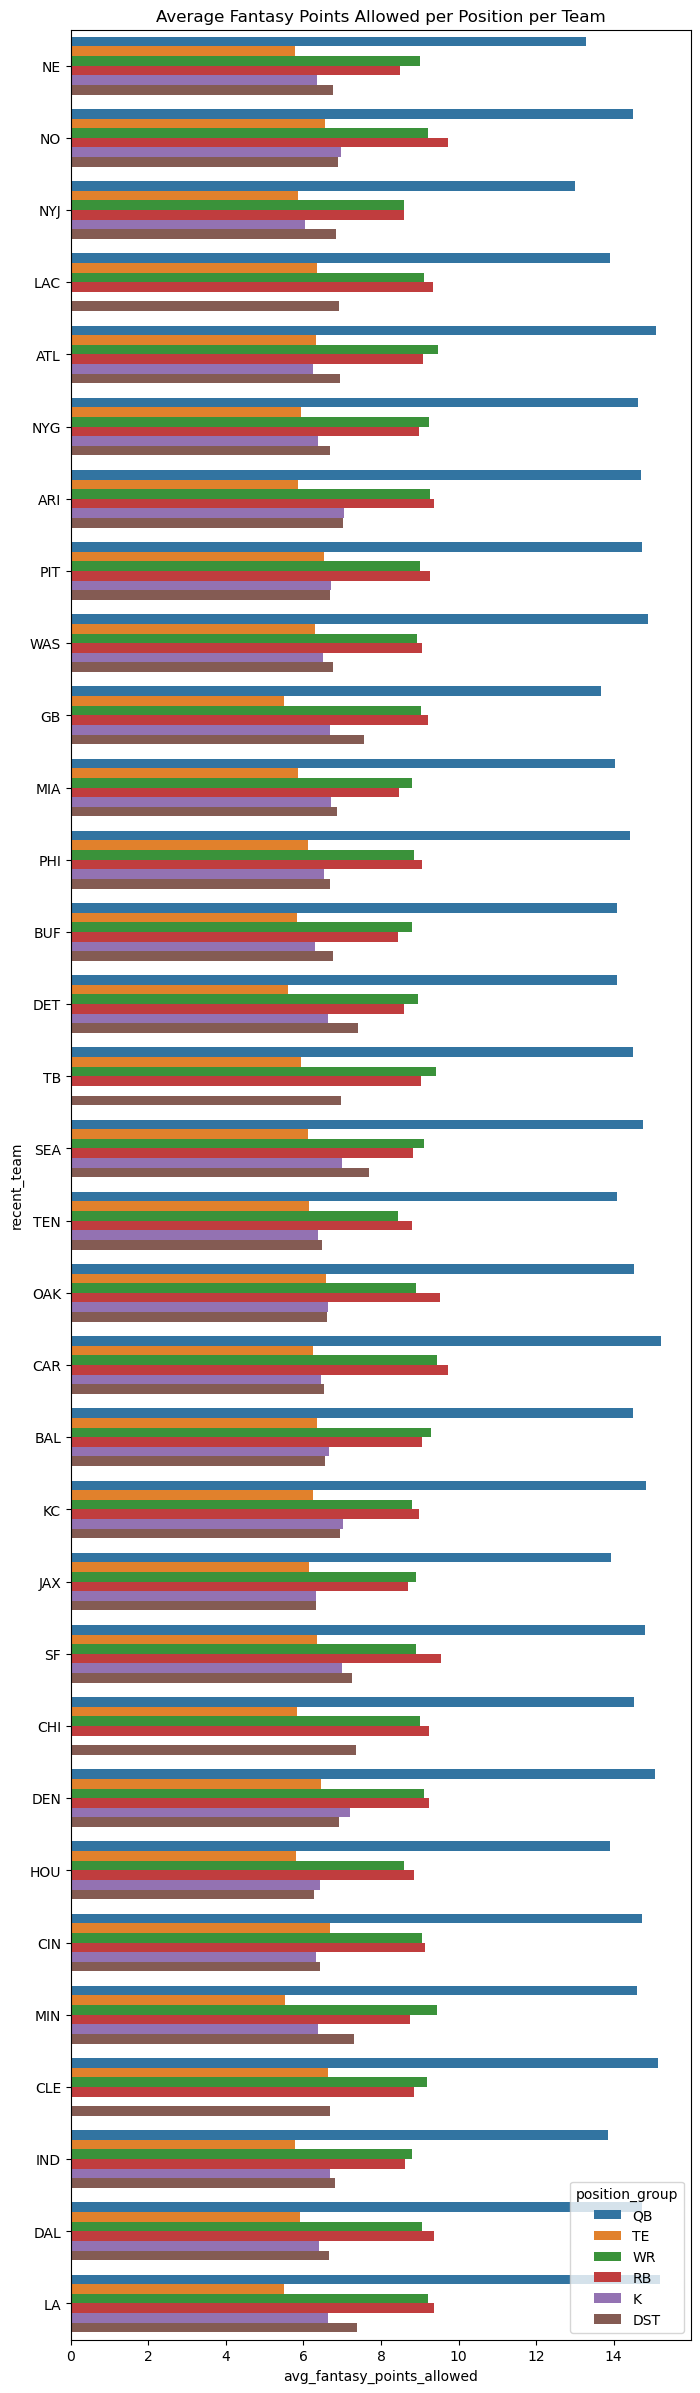

In [149]:
plt.figure(figsize=(8,30))
sns.barplot(y='recent_team', x='avg_fantasy_points_allowed', hue='position_group', data=player_data_1, ci=None)
plt.title('Average Fantasy Points Allowed per Position per Team')

# Speichern der Figur als PDF
plt.savefig("allowed_points.pdf", format='pdf')
